In [1]:
from article_process import ArticleLM

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

In [3]:
path_to_data = '/Users/stephanie/data/newsela_article_corpus_2016-01-29'
path_to_kenlm = '/Users/stephanie/github/kenlm'
path_to_arpa = path_to_kenlm + '/lm'

In [4]:
articleLM = ArticleLM(path_to_data, path_to_kenlm, path_to_arpa, 5, 'grade_level', False)

In [5]:
len(articleLM.metadata_split[articleLM.metadata_split.train_val_test == 'train'])

6916

In [6]:
len(articleLM.metadata_split[articleLM.metadata_split.train_val_test == 'val'])

867

## Builds the processed sentences that I need for KenLM

In [7]:
articleLM.build_data()

In [ ]:
articleLM.train_all_arpas()

## Printing out stats

how many sentences there are in training set, indexed by grade level?

In [8]:
for g in articleLM.level_sentences.get('train').keys():
    print(g, len(articleLM.level_sentences.get('train').get(g)))

8 42711
5 59271
3 18510
9 28725
7 52386
4 71524
2 7742
6 47525


In [9]:
# Number of sentences, train
sentence_len = 0
for g in articleLM.level_sentences.get('train').keys():
    sentence_len+=len(articleLM.level_sentences.get('train').get(g))
    
print(sentence_len)

328394


In [10]:
# Number of sentences, validation
sentence_len = 0
for g in articleLM.level_sentences.get('val').keys():
    sentence_len+=len(articleLM.level_sentences.get('val').get(g))
print(sentence_len)

41694


how many articles there are in each set, indexed by grade level?

In [11]:
articleLM.metadata_split[articleLM.metadata_split.train_val_test=='train'].grade_level.value_counts()

4     1386
5     1165
7     1091
6      942
8      918
9      687
3      501
2      225
12       1
Name: grade_level, dtype: int64

In [12]:
articleLM.metadata_split[articleLM.metadata_split.train_val_test=='train'].grade_level.value_counts().sum()

6916

In [13]:
articleLM.metadata_split[articleLM.metadata_split.train_val_test=='val'].grade_level.value_counts()

4    164
5    151
7    150
6    120
8    115
9     86
3     55
2     26
Name: grade_level, dtype: int64

## Comparing perplexities to Classify Sentences

In [23]:
# sentence_guesses = articleLM.compute_all_sentences_best_guess([2, 3, 4, 5, 6, 7, 8, 9])

Grade Level 11 failed
Grade Level 13 failed


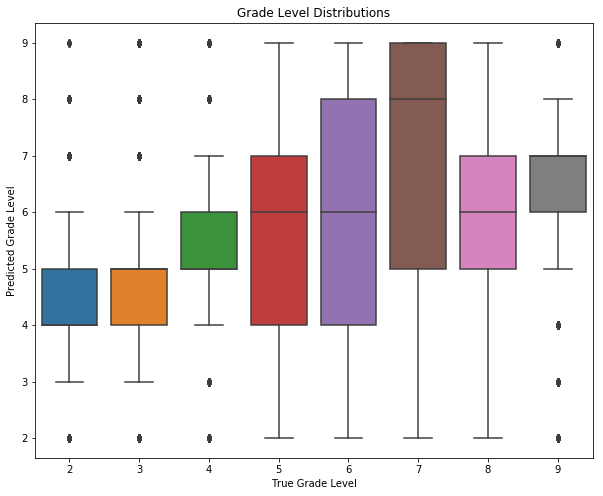

In [14]:
sentence_guesses = articleLM.plot_sentence_distribution([2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(sentence_guesses.level, sentence_guesses.best_guess)

In [16]:
cm

array([[ 138,  126,  508,  119,  148,   31,   25,    8],
       [ 160,  173,  601,  682,  163,  177,  102,   59],
       [ 383,  451,  624, 3095, 2077,  877,  708,  207],
       [  94,  506, 2355,  255, 1615, 1860,  575,  382],
       [ 121,  224, 1373, 1208,  135,  718, 1710,  477],
       [  94,  166,  817, 1423,  863,  220, 1713, 2252],
       [  73,  104,  703,  700, 1576, 1630,  203,  327],
       [  47,   58,  265,  474,  415, 1845,  315,  161]])

In [17]:
accuracy_score(sentence_guesses.level, sentence_guesses.best_guess)

0.04578596440734878

In [18]:
len(sentence_guesses[sentence_guesses.level == sentence_guesses.best_guess]) / len(sentence_guesses)

0.04578596440734878

Sentence level accuracy is really poor!

## Article level
Instead of trying to predict _each sentence_, we will pick the best grade level by categorizing the entire article after classifying the sentences. In this instance, I'm using means to find the best classification.

In [19]:
article_train_df = articleLM.compute_article_to_sentence_guess('train')

iteration 100, article ('USCHINA-TOURISM', 4)
iteration 200, article ('ahmed-clockteacher', 7)
iteration 300, article ('angrybirds-spying', 4)
iteration 400, article ('artist-housing', 9)
iteration 500, article ('bakery-autism', 7)
iteration 600, article ('beijing-smokingban', 5)
iteration 700, article ('bollywood-high', 5)
iteration 800, article ('brianwilliams-suspend', 7)
iteration 900, article ('camping-fires', 6)
iteration 1000, article ('cheerleader-downssyndrome', 5)
iteration 1100, article ('china-internet', 6)
iteration 1200, article ('christie-surgery', 5)
iteration 1300, article ('cocoa-labor', 9)
iteration 1400, article ('condor-cameras', 3)
iteration 1500, article ('cuba-terrorismlist', 4)
iteration 1600, article ('diamond-heist', 5)
iteration 1700, article ('doctor-shortage', 8)
iteration 1800, article ('dye-library', 5)
iteration 1900, article ('egypt-antiquities', 7)
iteration 2000, article ('everest-sherpas', 5)
iteration 2100, article ('ferguson-agency', 5)
iteration 

In [20]:
article_val_df = articleLM.compute_article_to_sentence_guess('val')

iteration 100, article ('boyscouts-gayleaders', 4)
iteration 200, article ('declining-fitness', 4)
iteration 300, article ('gadgets-pollution', 8)
iteration 400, article ('liberia-ebolafree', 7)
iteration 500, article ('norway-sun', 4)
iteration 600, article ('sabbath-debate', 5)
iteration 700, article ('testtube-meat', 7)


In [21]:
article_train_df[['predicted_gl', 'true_gl', 'article']].head()

,predicted_gl,true_gl,article
0,8,8,10dollarbill-woman
1,8,8,10dollarbill-woman
2,8,8,10dollarbill-woman
3,8,8,10dollarbill-woman
4,8,8,10dollarbill-woman


## Linear Regression to pick best article

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
article_train_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0).head()

predicted_gl                  2   3   4  5   6  7  8  9
true_gl article                                        
2       17century-selfies  7654  18  51  7  10  2  0  0
        Hospital-bootcamp    41   0   1  1   0  0  0  0
        Iditarod-finish      60   0   0  0   0  0  0  0
        adidas-mascots       44   0   1  0   0  0  0  0
        africa-outlook       45   0   0  0   0  0  0  0

In [24]:
article_pred_gl_count = \
    np.array(article_train_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0))

In [25]:
y = np.array(article_train_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0).reset_index().true_gl)

In [26]:
X = np.divide(article_pred_gl_count,article_pred_gl_count.sum(axis=1).reshape(len(article_pred_gl_count),1))

In [27]:
clf = LinearRegression()
clf.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
article_val_pred_gl_count = \
    np.array(article_val_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0))

In [29]:
X_val = np.divide(article_val_pred_gl_count,
                  article_val_pred_gl_count.sum(axis=1).reshape(len(article_val_pred_gl_count),
                                                                1))

In [30]:
val_df = article_val_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0).reset_index()[['true_gl', 'article']]

val_df.loc[:,'predicted_gl'] = list(clf.predict(X_val))

In [31]:
val_df.loc[:,'predicted_gl'] = val_df.predicted_gl.astype('int')

### Accuracy for linear regression outputs

In [32]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [33]:
cm = confusion_matrix(val_df.true_gl, val_df.predicted_gl)

In [34]:
cm

array([[  0,   3,  21,   0,   0,   0,   0,   0],
       [  0,   2,  27,  15,   1,   2,   0,   0],
       [  0,   1,  12, 100,  32,   6,   0,   0],
       [  0,   0,  15,  66,  48,   5,   1,   0],
       [  0,   0,  11,  21,  50,  20,   5,   0],
       [  0,   0,   3,  22,  25,  47,  42,   1],
       [  0,   0,   2,  41,  46,   8,   5,   0],
       [  0,   0,   1,   9,  39,  24,   2,   0]])

In [35]:
val_df.loc[:,'within_1_grade'] = list(map(lambda x,y: 1
                                         if (y >= x-1 and y <= x+1)
                                         else 0 , val_df.true_gl, val_df.predicted_gl))

#### Accuracy:

In [36]:
len(val_df[val_df.within_1_grade == 1]) * 100. / len(val_df)

63.25224071702945

### Scores for binary classification using linear regression

In [37]:
val_df.loc[:,'true_easy'] = [1 if x <= 5 else 0 for x in val_df.true_gl]
val_df.loc[:,'predicted_easy'] = [1 if x <= 5 else 0 for x in val_df.predicted_gl]

In [38]:
accuracy_score(val_df.true_easy, val_df.predicted_easy)

0.737516005121639

## Scores for using means, validation set

In [39]:
article_val_df, means_val = articleLM.compute_article_best_guess('val')

iteration 100, article ('boyscouts-gayleaders', 4)
iteration 200, article ('declining-fitness', 4)
iteration 300, article ('gadgets-pollution', 8)
iteration 400, article ('liberia-ebolafree', 7)
iteration 500, article ('norway-sun', 4)
iteration 600, article ('sabbath-debate', 5)
iteration 700, article ('testtube-meat', 7)


In [64]:
article_train_df, means_train = articleLM.compute_article_best_guess('train')

iteration 100, article ('USCHINA-TOURISM', 4)
iteration 200, article ('ahmed-clockteacher', 7)
iteration 300, article ('angrybirds-spying', 4)
iteration 400, article ('artist-housing', 9)
iteration 500, article ('bakery-autism', 7)
iteration 600, article ('beijing-smokingban', 5)
iteration 700, article ('bollywood-high', 5)
iteration 800, article ('brianwilliams-suspend', 7)
iteration 900, article ('camping-fires', 6)
iteration 1000, article ('cheerleader-downssyndrome', 5)
iteration 1100, article ('china-internet', 6)
iteration 1200, article ('christie-surgery', 5)
iteration 1300, article ('cocoa-labor', 9)
iteration 1400, article ('condor-cameras', 3)
iteration 1500, article ('cuba-terrorismlist', 4)
iteration 1600, article ('diamond-heist', 5)
iteration 1700, article ('doctor-shortage', 8)
iteration 1800, article ('dye-library', 5)
iteration 1900, article ('egypt-antiquities', 7)
iteration 2000, article ('everest-sherpas', 5)
iteration 2100, article ('ferguson-agency', 5)
iteration 

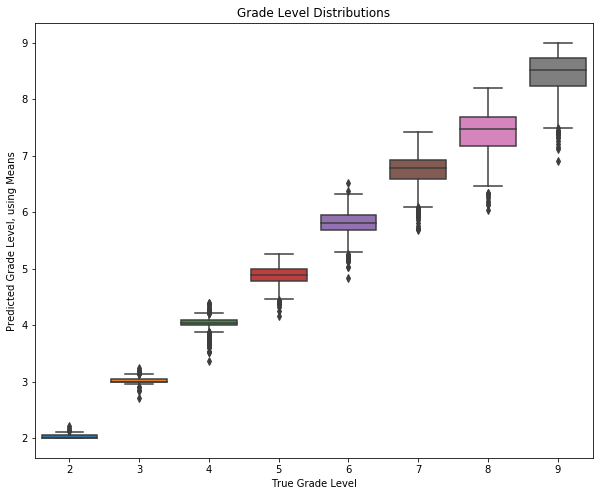

In [65]:
articleLM.plot_article_best_grade_levels(means_train)

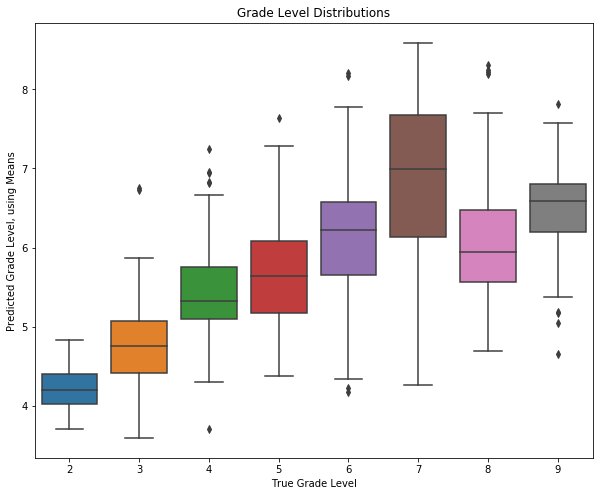

In [41]:
articleLM.plot_article_best_grade_levels(means_val)

In [42]:
means_val.head()

,article,true_gl,predicted_gl
0,10dollarbill-woman,6,6.076936
1,20dollarbill-female,6,6.404762
2,3d-indoormap,6,6.555556
3,Braille-startup,6,4.540984
4,Braille-startup,8,6.057750


In [44]:
(grade_level_cm, raw_accuracy, banded_accuracy,
 binary_cm, binary_accuracy, binary_f1) = articleLM.compute_scores_grade_level(means_val)

In [45]:
grade_level_cm

array([[ 0,  4, 20,  0,  0,  0,  0,  0],
       [ 0,  3, 31, 11,  2,  0,  0,  0],
       [ 0,  1, 25, 98, 26,  1,  0,  0],
       [ 0,  0, 21, 73, 37,  4,  0,  0],
       [ 0,  0, 17, 24, 51, 13,  2,  0],
       [ 0,  0,  3, 27, 40, 52, 18,  0],
       [ 0,  0,  6, 47, 44,  1,  4,  0],
       [ 0,  0,  1, 13, 55,  6,  0,  0]])

In [46]:
raw_accuracy

0.26632522407170295

In [47]:
banded_accuracy

0.6350832266325224

In [48]:
binary_cm

array([[286, 138],
       [ 70, 287]])

In [49]:
binary_accuracy

0.7336747759282971

In [50]:
binary_f1

0.7333333333333332

## Scores for using means, test set

iteration 100, article ('book-bike', 5)
iteration 200, article ('disney-shanghai', 4)
iteration 300, article ('healthcare-callcenter', 6)
iteration 400, article ('mexico-tv', 6)
iteration 500, article ('piano-upswing', 5)
iteration 600, article ('sleepy-schooltimes', 5)
iteration 700, article ('voting-lawsuit', 4)


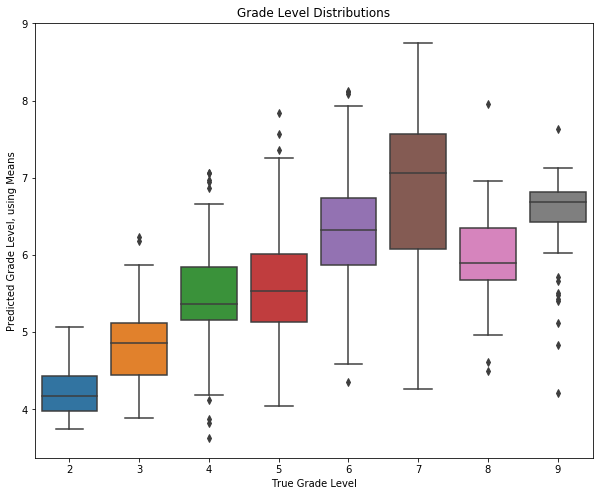

In [51]:
article_test_df, means_test = articleLM.compute_article_best_guess('test')
articleLM.plot_article_best_grade_levels(means_test)

In [52]:
(grade_level_cm, raw_accuracy, banded_accuracy,
 binary_cm, binary_accuracy, binary_f1) = articleLM.compute_scores_grade_level(means_test)

In [53]:
grade_level_cm

array([[ 0,  7, 17,  1,  0,  0,  0,  0],
       [ 0,  3, 25, 15,  2,  0,  0,  0],
       [ 0,  3, 18, 92, 27,  2,  0,  0],
       [ 0,  0, 26, 90, 31, 10,  0,  0],
       [ 0,  0, 10, 20, 52, 13,  3,  0],
       [ 0,  0,  9, 17, 24, 43, 14,  0],
       [ 0,  0,  4, 59, 38,  1,  0,  0],
       [ 0,  0,  2,  7, 45,  7,  0,  0]])

In [54]:
raw_accuracy

0.27951153324287653

In [55]:
banded_accuracy

0.6268656716417911

In [56]:
binary_cm

array([[240, 128],
       [ 72, 297]])

In [57]:
binary_accuracy

0.728629579375848

In [58]:
binary_f1

0.7058823529411764

### Just for fun, check linear regression score too.

In [59]:
article_test_pred_gl_count = \
    np.array(article_test_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0))

X_test = np.divide(article_test_pred_gl_count,
                  article_test_pred_gl_count.sum(axis=1).reshape(len(article_test_pred_gl_count),
                                                                1))

test_df = article_test_df[['true_gl', 'article', 'predicted_gl']].pivot_table(columns='predicted_gl',
                                                                     index=['true_gl', 'article'],
                                                                     aggfunc=lambda x:  len(x),
                                                                    fill_value=0).reset_index()[['true_gl', 'article']]

test_df.loc[:,'predicted_gl'] = list(clf.predict(X_test))
test_df.loc[:,'predicted_gl'] = test_df.predicted_gl.astype('int')

#### accuracy for regression outputs

In [60]:
test_df.loc[:,'within_1_grade'] = list(map(lambda x,y: 1
                                         if (y >= x-1 and y <= x+1)
                                         else 0 , test_df.true_gl, test_df.predicted_gl))

In [61]:
len(test_df[test_df.within_1_grade == 1]) * 100. / len(test_df)

test_df.loc[:,'true_easy'] = [1 if x <= 5 else 0 for x in test_df.true_gl]
test_df.loc[:,'predicted_easy'] = [1 if x <= 5 else 0 for x in test_df.predicted_gl]

accuracy_score(test_df.true_easy, test_df.predicted_easy)

0.7421981004070556

It's still not as good! Sticking with the means.